# Projeto oficial Disciplina Python: 
Como variações no tamanho da rede do volêi masculino alteram a performance (pontos, bloqueios, saques) dos jogadores?
Sabemos que o volêi moderno, especialmenete o masculino, evoluiu bastante em termos de performances dos jogadores. No sentido de que não há equipes em que os jogadores de ataque (ponteiros, opostos, levantadores) não ultrapassem facilmente os 3,30 cm de salto durante o ataque ou bloqueio. Isto considerando uma rede com altura de 2,43 cm é quase 1 metro de diferença. A competitividade a esse ponto elevou o nível do jogo a um patamar nunca antes visto na história do volêi mundial. Mesmo os jogadores de ataque com alturas inferiores a 1,90 cm (que sãp oconsiderados relativamente baixos para os padrões atuais) possuem bastante facilidade para atingir alturas de até 1 metro acima do limite superior da rede. 

O mais impressionante é que a performance desses jogadores consegue ser mantida quase sempre durante todo os sets do jogo, independentemente se são jogados em 3 sets ou 5 em caso de tie-break. A disputa nos dias atuais portanto é em força, velocidade, e impulsão e por ultimo habilidade. Apesar de soar controlverso, muito se tem discutido que o volei masculino preza sobretudo por muitas outras caracteristicas em detrimento da habilidade e destresa da performance, justamente pelo fato da altura (algo endógeno e inato do jogador) e força serem fatores preponderantes sobre outras características. Obviamente isto não supera um equilíbrio entre todo o conjunto de caracteristicas, pois um exceletne jogador possui bons fundamentos adquiridos com treinos somados a ter uma boa altura e capacidade física. 

Isto é um fato, apenas altura e força não bastam. Entretando a medida em que elas são capazes de determinar o que é seria um "bom jogador" é algo que revela o quão determinantes para isso elas são. 

Com isso, vou tentar fazer um modelo me machine learning para prever como a performance dos jogadores é alterada com aumentos marginais (cm) na altura da rede. Isso lhes trás mais vantagem? Quais tipos de jogadores se beneficiariam mais? É correto dizer que isso é bom para o esporte como um todo ou só está punindo aqueles que possuem uma característica inata que lhes da maior vantagem sobre os outros? Essas e outras perguntas motivaram este estudo e ao longo das próximas células irei tentar esclarecêlas.

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import json

name = "PLAYERS_BIO_MEN'S_PLUS_LEAGUE_ALL_STATS.json"
with open(name, 'r') as json_file:
    dt = json.load(json_file)
    

data = pd.DataFrame(dt)
data


,matches_played,sets_played,points,serves,aces,serves_mistakes,aces_per_set,reception,reception_mistakes,reception_bad,...,attacks_perfect%,blocks_points,blocks_points_perset,player_name,player_age,player_height_cm,player_weight_kg,player_jump_height_cm,player_position,player_id
0,43,141,161,404,25,78,"0,1773",45,5,20,...,"55,6886",43,"0,3050",Jakub Abramowicz,10/04/1998,202,90,350,Środkowy,2100171
1,20,72,222,290,12,38,"0,1667",431,40,128,...,"46,3054",22,"0,3056",Adrian Aciobăniței,24/08/1997,193,78,337,Przyjmujący,2124367
2,43,116,203,337,12,71,"0,1034",65,7,11,...,"59,8291",51,"0,4397",Sebastian Adamczyk,28/02/1999,208,98,350,Środkowy,27975
3,19,61,116,126,11,34,"0,1803",145,13,35,...,"45,2632",19,"0,3115",Manuel Armoa,01/12/2002,198,84,330,Przyjmujący,2125173
4,63,216,501,804,45,151,"0,2083",24,2,5,...,"64,8649",120,"0,5556",Taylor Averill,05/03/1992,201,93,370,Środkowy,2102337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Justin Ziółkowski,09/06/1998,196,90,330,Przyjmujący,2135146
256,371,1348,2413,4722,211,453,"0,1565",328,20,62,...,"56,8991",668,"0,4955",Miłosz Zniszczoł,02/07/1986,201,102,345,Środkowy,372
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Bartosz Zych,15/07/2006,203,86,353,Przyjmujący,2115603
258,40,82,57,56,3,13,"0,0366",1,0,1,...,"40,1709",7,"0,0854",Arkadiusz Żakieta,13/10/1992,197,94,355,Atakujący,2100071


Fazendo algumas manipulações no dataset para obter o conjunto ideal de dados para a análise

In [2]:
data.replace(',', '.', regex=True, inplace=True)
data.replace(" ", "", regex=True, inplace=True)
data.replace('','0',regex=True, inplace=True)
data.replace("'",'',regex=True,inplace=True)

In [ ]:
data['net_size_current'] = '243'
data['diff_net_player_jump'] = data['player_jump_height_cm'].astype(int) - data['net_size_current'].astype(int)
data['diff_player_jump_to_heigh'] = data['player_jump_height_cm'].astype(int) - data['player_height_cm'].astype(int)
data


In [4]:
data['player_position'] = data['player_position'].replace({
    'Środkowy': 'Middle',
    'Przyjmujący': 'Outside Hitter',
    'Libero': 'Libero',
    'Rozgrywający': 'Setter',
    'Atakujący': 'Opposite Hitter'
})


In [5]:
data_oficial = data[data['player_position'].isin(['Middle', 'Outside Hitter', 'Opposite Hitter'])]
data_oficial

,matches_played,sets_played,points,serves,aces,serves_mistakes,aces_per_set,reception,reception_mistakes,reception_bad,...,player_name,player_age,player_height_cm,player_weight_kg,player_jump_height_cm,player_position,player_id,net_size_current,diff_net_player_jump,diff_player_jump_to_heigh
0,43,141,161,404,25,78,0.1773,45,5,20,...,JakubAbramowicz,10/04/1998,202,90,350,Middle,2100171,243,107,148
1,20,72,222,290,12,38,0.1667,431,40,128,...,AdrianAciobăniței,24/08/1997,193,78,337,Outside Hitter,2124367,243,94,144
2,43,116,203,337,12,71,0.1034,65,7,11,...,SebastianAdamczyk,28/02/1999,208,98,350,Middle,27975,243,107,142
3,19,61,116,126,11,34,0.1803,145,13,35,...,ManuelArmoa,01/12/2002,198,84,330,Outside Hitter,2125173,243,87,132
4,63,216,501,804,45,151,0.2083,24,2,5,...,TaylorAverill,05/03/1992,201,93,370,Middle,2102337,243,127,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,JustinZiółkowski,09/06/1998,196,90,330,Outside Hitter,2135146,243,87,134
256,371,1348,2413,4722,211,453,0.1565,328,20,62,...,MiłoszZniszczoł,02/07/1986,201,102,345,Middle,372,243,102,144
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,BartoszZych,15/07/2006,203,86,353,Outside Hitter,2115603,243,110,150
258,40,82,57,56,3,13,0.0366,1,0,1,...,ArkadiuszŻakieta,13/10/1992,197,94,355,Opposite Hitter,2100071,243,112,158


In [6]:
data_oficial['points'].fillna(0, inplace=True)
data_oficial['points'] = data_oficial['points'].astype(int)
mean_jump_height = data_oficial['player_jump_height_cm'].mean()
data_oficial['player_jump_height_cm'].fillna(mean_jump_height, inplace=True)

C:\Users\estev\AppData\Local\Temp\ipykernel_25800\2791689155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oficial['points'].fillna(0, inplace=True)
C:\Users\estev\AppData\Local\Temp\ipykernel_25800\2791689155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oficial['points'] = data_oficial['points'].astype(int)
C:\Users\estev\AppData\Local\Temp\ipykernel_25800\2791689155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [7]:
data_oficial = data[data['player_position'].isin(['Middle', 'Outside Hitter', 'Opposite Hitter'])]
pd.to_numeric(data_oficial['points'])
pd.to_numeric(data_oficial['player_height_cm'])
pd.to_numeric(data_oficial['player_jump_height_cm'])
pd.to_numeric(data_oficial['player_weight_kg'])
data_oficial = data_oficial.query('matches_played.notna() and matches_played != 0')
data_oficial

,matches_played,sets_played,points,serves,aces,serves_mistakes,aces_per_set,reception,reception_mistakes,reception_bad,...,player_name,player_age,player_height_cm,player_weight_kg,player_jump_height_cm,player_position,player_id,net_size_current,diff_net_player_jump,diff_player_jump_to_heigh
0,43,141,161,404,25,78,0.1773,45,5,20,...,JakubAbramowicz,10/04/1998,202,90,350,Middle,2100171,243,107,148
1,20,72,222,290,12,38,0.1667,431,40,128,...,AdrianAciobăniței,24/08/1997,193,78,337,Outside Hitter,2124367,243,94,144
2,43,116,203,337,12,71,0.1034,65,7,11,...,SebastianAdamczyk,28/02/1999,208,98,350,Middle,27975,243,107,142
3,19,61,116,126,11,34,0.1803,145,13,35,...,ManuelArmoa,01/12/2002,198,84,330,Outside Hitter,2125173,243,87,132
4,63,216,501,804,45,151,0.2083,24,2,5,...,TaylorAverill,05/03/1992,201,93,370,Middle,2102337,243,127,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,5,17,16,58,2,6,0.1176,130,11,43,...,KrzysztofZapłacki,08/08/1993,197,90,340,Outside Hitter,2100252,243,97,143
253,46,158,257,387,14,57,0.0886,99,5,22,...,NicolasZerba,13/06/1999,204,95,345,Middle,2106054,243,102,141
256,371,1348,2413,4722,211,453,0.1565,328,20,62,...,MiłoszZniszczoł,02/07/1986,201,102,345,Middle,372,243,102,144
258,40,82,57,56,3,13,0.0366,1,0,1,...,ArkadiuszŻakieta,13/10/1992,197,94,355,Opposite Hitter,2100071,243,112,158


C:\Users\estev\AppData\Local\Temp\ipykernel_25800\3872183949.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[cols_to_convert] = data_filtered[cols_to_convert].astype(int)


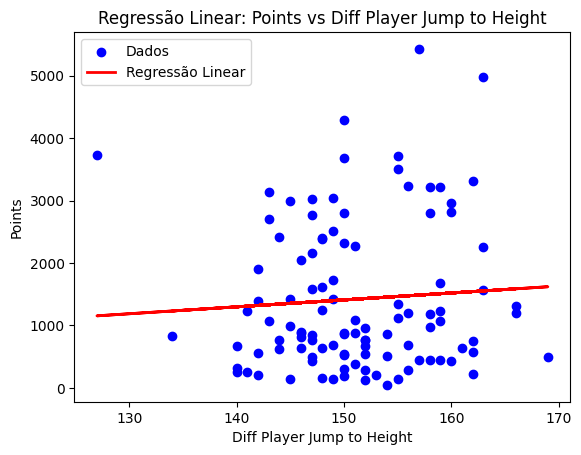

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Convertendo 'matches_played' para tipo numérico
data_oficial['matches_played'] = pd.to_numeric(data_oficial['matches_played'], errors='coerce')

# Filtrar jogadores com mais de 40 partidas jogadas
data_filtered = data_oficial[data_oficial['matches_played'] > 40]

# Selecionar as colunas desejadas
cols_to_convert = ['diff_player_jump_to_heigh', 'player_height_cm', 'player_weight_kg', 'points']

# Converter as colunas relevantes para int
data_filtered[cols_to_convert] = data_filtered[cols_to_convert].astype(int)

# Criar o modelo de regressão linear
X = sm.add_constant(data_filtered['diff_player_jump_to_heigh']) # Adicionando uma constante para o termo independente
y = data_filtered['points']
model = sm.OLS(y, X)

# Ajustar o modelo aos dados
results = model.fit()

# Scatter plot dos dados
plt.scatter(data_filtered['diff_player_jump_to_heigh'], data_filtered['points'], color='blue', label='Dados')

# Plot da linha de regressão
plt.plot(data_filtered['diff_player_jump_to_heigh'], results.predict(X), color='red', linewidth=2, label='Regressão Linear')

# Adicionar rótulos e título
plt.xlabel('Diff Player Jump to Height')
plt.ylabel('Points')
plt.title('Regressão Linear: Points vs Diff Player Jump to Height')
plt.legend()

# Mostrar o gráfico
plt.show()


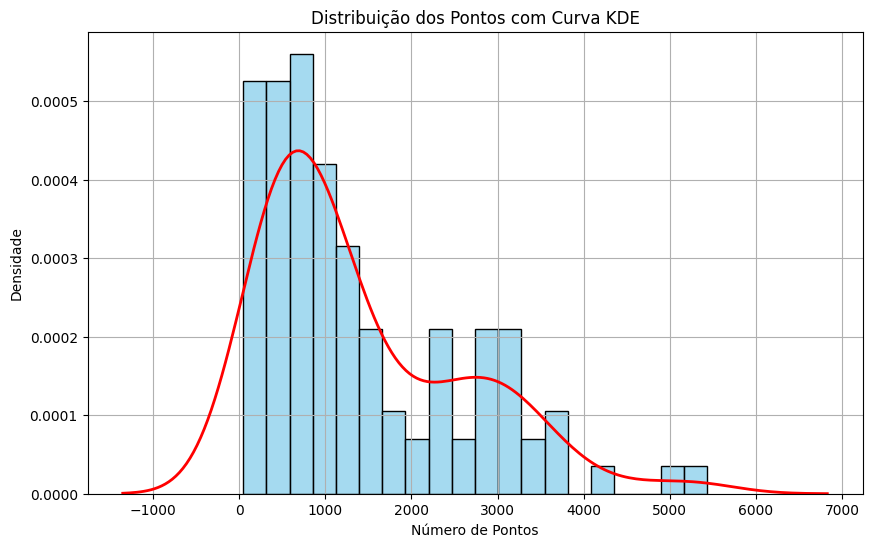

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar o histograma
plt.figure(figsize=(10, 6))
sns.histplot(data=data_filtered, x='points', bins=20, color='skyblue', stat='density', kde=False)
# Adicionar a curva KDE separadamente
sns.kdeplot(data=data_filtered, x='points', color='red', linewidth=2)
plt.xlabel('Número de Pontos')
plt.ylabel('Densidade')
plt.title('Distribuição dos Pontos com Curva KDE')
plt.grid(True)
plt.show()
